In [1]:
pip install scikit-learn matplotlib seaborn joblib


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    RocCurveDisplay
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

In [2]:
df = pd.read_csv("ai4i2020_cleaned.csv")
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Temp diff [K]
0,M,298.1,308.6,1551.0,42.8,0,0,10.5
1,L,298.2,308.7,1408.0,46.3,3,0,10.5
2,L,298.1,308.5,1498.0,49.4,5,0,10.4
3,L,298.2,308.6,1433.0,39.5,7,0,10.4
4,L,298.2,308.7,1408.0,40.0,9,0,10.5


In [3]:
X = df.drop(columns=["Machine failure"])
y = df["Machine failure"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [5]:
cat_cols = ["Type"]                # only categorical
num_cols = [c for c in X.columns if c not in cat_cols]

In [6]:
from sklearn.impute import SimpleImputer

preprocess = ColumnTransformer([
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols)
])

In [7]:
from sklearn.dummy import DummyClassifier
dummy = Pipeline([("prep", preprocess),
                  ("model", DummyClassifier(strategy="most_frequent"))])
dummy.fit(X_train, y_train)
print("Dummy accuracy:", dummy.score(X_test, y_test))

Dummy accuracy: 0.966


In [8]:
logreg = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
logreg.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]',
                                                   'Temp diff [K]'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [26]:
y_pred_lr  = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]

In [31]:
from sklearn.metrics import classification_report, roc_auc_score

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      1932
           1       0.12      0.76      0.20        68

    accuracy                           0.80      2000
   macro avg       0.55      0.78      0.54      2000
weighted avg       0.96      0.80      0.86      2000

ROC-AUC: 0.8797421142369992


In [9]:
rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])
rf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]',
                                                   'Temp diff [K]'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [28]:
y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [32]:
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.91      0.59      0.71        68

    accuracy                           0.98      2000
   macro avg       0.95      0.79      0.85      2000
weighted avg       0.98      0.98      0.98      2000

ROC-AUC: 0.9690087991718427


In [10]:
def evaluate(model, name):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:,1]
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_test, pred))
    print("Precision:", precision_score(y_test, pred))
    print("Recall   :", recall_score(y_test, pred))
    print("F1       :", f1_score(y_test, pred))
    print("ROC-AUC  :", roc_auc_score(y_test, prob))
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    RocCurveDisplay.from_predictions(y_test, prob)
    plt.title(f"ROC Curve - {name}")
    plt.show()


Logistic Regression
Accuracy : 0.796
Precision: 0.11711711711711711
Recall   : 0.7647058823529411
F1       : 0.203125
ROC-AUC  : 0.8797421142369992


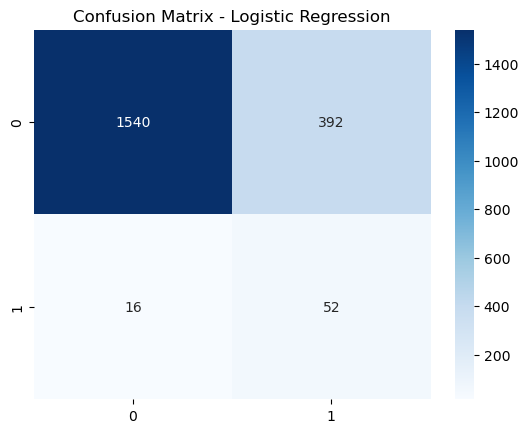

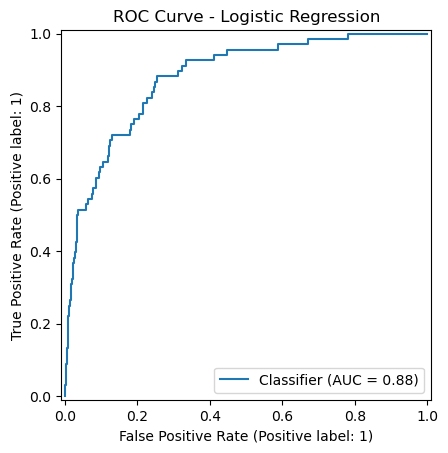


Random Forest
Accuracy : 0.984
Precision: 0.9090909090909091
Recall   : 0.5882352941176471
F1       : 0.7142857142857143
ROC-AUC  : 0.9690087991718427


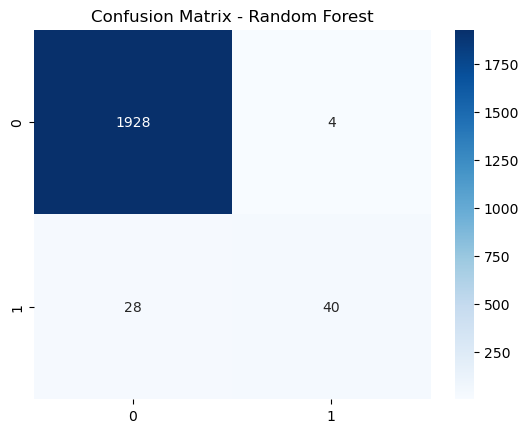

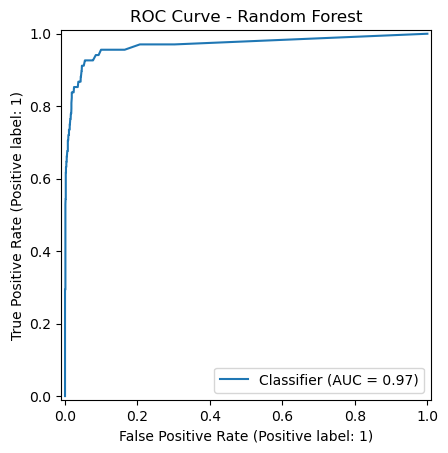

In [11]:
evaluate(logreg, "Logistic Regression")
evaluate(rf, "Random Forest")

In [12]:
best_model = rf

In [13]:
joblib.dump(best_model, "best_model_pipeline.joblib")

['best_model_pipeline.joblib']

In [35]:
sample = X_test.iloc[[0]]
prob = best_model.predict_proba(sample)[0,1]
pred = best_model.predict(sample)[0]
print("Failure probability:", prob, "Predicted label:", pred)

Failure probability: 0.3233333333333333 Predicted label: 0


In [34]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc = cross_val_score(best_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print("CV ROC-AUC:", roc.mean(), "+/-", roc.std())

CV ROC-AUC: 0.9631036074656139 +/- 0.004443547562263277


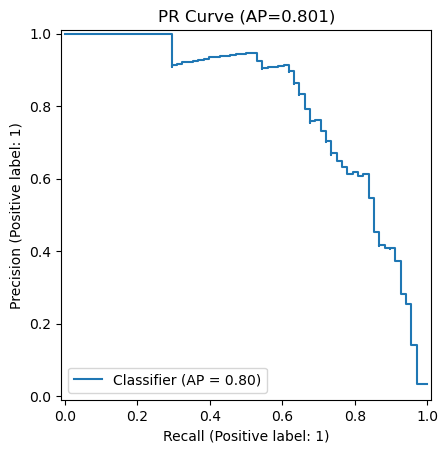

In [36]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
probs = best_model.predict_proba(X_test)[:,1]
ap = average_precision_score(y_test, probs)
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.title(f"PR Curve (AP={ap:.3f})"); plt.show()


In [23]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

probs = best_model.predict_proba(X_test)[:,1]
thresholds = np.linspace(0.05, 0.9, 18)

rows = []
for t in thresholds:
    pred = (probs >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, pred, zero_division=0),
        "recall": recall_score(y_test, pred, zero_division=0),
        "f1": f1_score(y_test, pred, zero_division=0),
    })
pd.DataFrame(rows)

,threshold,precision,recall,f1
0,0.05,0.346154,0.926471,0.504000
1,0.10,0.430657,0.867647,0.575610
2,0.15,0.537037,0.852941,0.659091
3,0.20,0.630952,0.779412,0.697368
4,0.25,0.700000,0.720588,0.710145
5,0.30,0.731343,0.720588,0.725926
6,0.35,0.793103,0.676471,0.730159
7,0.40,0.862745,0.647059,0.739496
8,0.45,0.911111,0.602941,0.725664
9,0.50,0.909091,0.588235,0.714286


In [24]:
from sklearn.metrics import confusion_matrix
t = 0.30  # example chosen
pred_t = (probs >= t).astype(int)
cm = confusion_matrix(y_test, pred_t)
cm

array([[1914,   18],
       [  19,   49]])

In [28]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(best_model, method="isotonic", cv=5)
calibrated.fit(X_train, y_train)
cal_probs = calibrated.predict_proba(X_test)[:,1]
print("Calibrated ROC-AUC:", roc_auc_score(y_test, cal_probs))

Calibrated ROC-AUC: 0.9665083424674218


In [36]:
# Grab the fitted preprocessing transformer and the trained RF model
prep = best_model.named_steps["prep"]
rf   = best_model.named_steps["model"]

X_test_trans = prep.transform(X_test)

from sklearn.inspection import permutation_importance
r = permutation_importance(rf, X_test_trans, y_test, n_repeats=10,
                           scoring="roc_auc", random_state=42)

# Now the lengths match the transformed feature names
feature_names = prep.get_feature_names_out()
imp = pd.DataFrame({
    "feature": feature_names,
    "importance": r.importances_mean
}).sort_values("importance", ascending=False)
imp


,feature,importance
7,num__Tool wear [min],0.113835
5,num__Rotational speed [rpm],0.065177
6,num__Torque [Nm],0.064381
8,num__Temp diff [K],0.017650
1,cat__Type_L,0.001476
0,cat__Type_H,-0.000014
2,cat__Type_M,-0.000101
4,num__Process temperature [K],-0.002974
3,num__Air temperature [K],-0.003400


In [38]:
import joblib, json
joblib.dump(best_model, "best_model_pipeline.joblib")
with open("decision_threshold.json", "w") as f:
    json.dump({"threshold": 0.30}, f)


In [33]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Recall (Fail=1)": [
        classification_report(y_test, y_pred_lr, output_dict=True)["1"]["recall"],
        classification_report(y_test, y_pred_rf, output_dict=True)["1"]["recall"]
    ],
    "F1": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf)
    ]
})
results


,Model,Accuracy,Recall (Fail=1),F1,ROC-AUC
0,Logistic Regression,0.796,0.764706,0.203125,0.879742
1,Random Forest,0.984,0.588235,0.714286,0.969009
